In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [2]:
# function for splitting the dataset indices into training (75%) and testing (25%) sets
def select_indices_percent(data, train_frac=0.75, shuffle=True):
    indices = np.arange(len(data))
    
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    
    split = int(len(indices) * train_frac)
    train_indices = indices[:split]
    test_indices = indices[split:]
    return train_indices, test_indices


# function for splitting the dataset indices into training (30 stations) and testing (1 station) sets
def select_indices_station(data, station):
    indices = set(np.arange(len(data)))
    train_indices = np.array(data.loc[data.station != station].index)
    test_indices = np.array(list(indices - set(train_indices)))
    return train_indices, test_indices


# function for making the train and test sets
def make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100 = False, print_shapes=False):
    # predictor variables
    X_train = np.array(np.take(data[predictors], train_indices, 0))
    X_test = np.array(np.take(data[predictors], test_indices, 0))

    # n100 concentration
    y_train = None
    y_test = None
    log_y_test = np.array(np.take(data.n100_log, test_indices, 0))
    orig_y_test = np.array(np.take(data.n100, test_indices, 0))

    if not log_transf_n100:
        y_train = np.array(np.take(data.n100, train_indices, 0))
        y_test = orig_y_test
    else:
        y_train = np.array(np.take(data.n100_log, train_indices, 0))
        y_test = log_y_test

    if print_shapes:
        print('Train set shapes:', X_train.shape, 'and', y_train.shape)
        print('Test set shapes:', X_test.shape, 'and', y_test.shape)
        
    return X_train, X_test, y_train, y_test, log_y_test, orig_y_test


# function for calculating the correlation between two variables
def get_corr(a, b, pr=3):
    corr = pearsonr(a, b)[0]
    corr = np.round(corr, pr)
    return str(corr)


# function for calculating the R2 value and RMSLE
def eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=False):
    r2 = np.round(r2_score(orig_y_test, predictions), 4)
    r2_log = np.round(r2_score(log_y_test, log_predictions), 4)
    rmsle = np.round(np.sqrt(mean_squared_log_error(orig_y_test, predictions)), 4)
    rmse_log = np.round(np.sqrt(mean_squared_error(log_y_test, log_predictions)), 4)
    
    if print_results:
        print('R2 value on test set: %f' % r2)
        print('R2 value on test set (log-transformed): %f' % r2_log)
        print('RMSLE on test set: %f' % rmsle)
        print('RMSE on test set (log_transformed): %f' % rmse_log)
        
    return r2, r2_log, rmsle, rmse_log


# function for printing the equation created by the linear regression model
def print_equation(model, predictors, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'n100 =' if not log_transf_n100 else 'n100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions, observations, log_transf=False, station=None):
    corr = get_corr(observations, predictions)
    axis_min = max(0, min(observations.min(), predictions.min()) - 0.5)
    axis_max = max(observations.max(), predictions.max()) + 0.5
    
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(axis_min, axis_max+1), np.arange(axis_min, axis_max+1), c='black', alpha=0.25)
    plt.scatter(observations, predictions, s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    title = 'Observed vs. Predicted n100 Concentration'
    output = 'Correlation between observed and predicted n100 concentration'
    
    if log_transf:
        title += ' (log-transformed)'
        output += ' (log-transformed)'
        
    if station != None:
        title += ' - ' + station
        
    plt.title(title)
    print(output + ': ' + corr)
    
    
# function for plotting observed and predicted n100 concentrations (log-scale)
def plot_results(name, predictions):
    plt.figure(figsize=(10, 5))
    plt.title('Performance of ' + name + ' Model')
    plt.plot(log_y_test, label='Observed', lw=0.5)
    plt.plot(predictions, label='Predicted', alpha=0.75, lw=0.5)
    plt.xlabel('Observation')
    plt.ylabel('n100 Concentration (log-transformed)')
    plt.ylim(0, 12)
    plt.legend()
    

# function for plotting the distribution of residuals (in log-scale) to check if errors are normally distributed
def plot_residuals(name, predictions):
    plt.figure(figsize=(6, 4))
    plt.title('Residual of Predictions for ' + name + ' Model')
    plt.hist(log_y_test - predictions, bins=200)
    plt.ylabel('Frequency')
    plt.xlabel('Residual')
    plt.xlim(-10, 10)

In [4]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'FKL', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 'MLP', 
          'MUK', 'NAN', 'NEU', 'POV', 'PRL', 'SAO', 'SCH', 'SGP', 'UAE', 'VAR', 
          'VHL', 'VIE', 'WAL', 'ZOT']

variables = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
             'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11', 'co', 'c5h8', 'c10h16', 
             'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 'crwc', 'blh', 'rh', 
             'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 
                  'latitude', 'longitude_sin', 'longitude_cos']

all_vars = ['doy_sin', 'doy_cos',
            'latitude', 'longitude_sin', 'longitude_cos',
            'aermr01', 'aermr02', 'aermr03',
            'aermr01_log', 'aermr02_log', 'aermr03_log',
            'aermr04', 'aermr05', 'aermr06',
            'aermr04_log', 'aermr05_log', 'aermr06_log',
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11',
            'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 'aermr11_log',
            'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 
            'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log',
            'd2m', 't2m', 'blh', 'rh', 'crwc', 'crwc_log']

In [5]:
# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed values that are < 1 become negative, which doesn't make sense
data.loc[data.n100 < 1, 'n100'] = 1

# log-transforming selected variables
for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed > 0, transformed[transformed > 0].min())
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr10_log,aermr11_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-21.309149,-21.085343,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-21.181645,-21.136839,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-20.943542,-20.573239,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-21.326093,-19.603823,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-21.669206,-19.666249,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861


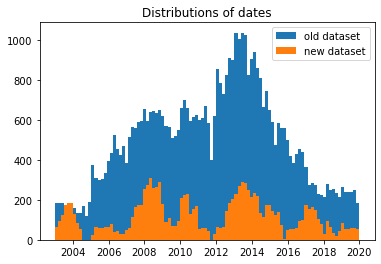

In [6]:
date_ranges = pd.read_csv('metadata/date_ranges_of_stations.csv', parse_dates=['start_date', 'end_date'], dayfirst=True)
date_ranges.head()

new_data = []

for c in cities:
    sd = date_ranges.start_date.loc[date_ranges.station == c].iloc[0]
    ed = date_ranges.end_date.loc[date_ranges.station == c].iloc[0]
    c_data = data.loc[data.station == c]
    c_data = c_data.loc[c_data.date >= sd]
    c_data = c_data.loc[c_data.date <= ed]
    new_data.append(c_data)

new_data = pd.concat(new_data)
new_data = new_data.reset_index(drop=True)

plt.hist(data.date, bins=100, label='old dataset')
plt.hist(new_data.date, bins=100, label='new dataset')
plt.title('Distributions of dates')
plt.legend()

old_data = data
data = new_data

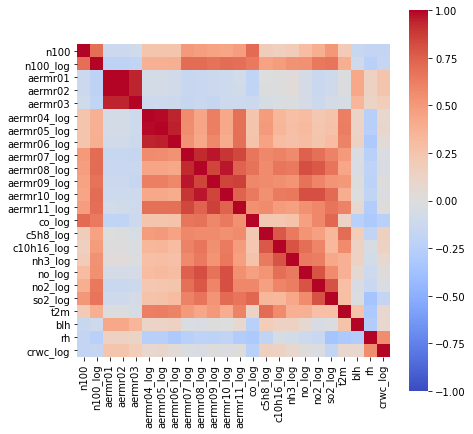

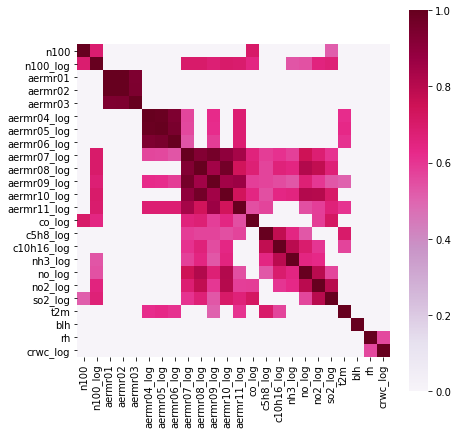

In [17]:
# predictors = ['aermr01_log', 'aermr02_log', 'aermr03_log',
#               'aermr04_log', 'aermr05_log', 'aermr06_log',
#               'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log']

# predictors = ['co_log', 'c5h8_log', 'no_log', 'no2_log', 'so2_log',
#               'd2m', 't2m', 'blh', 'rh', 'crwc_log', 'nh3_log', 'c10h16_log']

# predictors = ['aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 
#               'co_log', 'no_log', 'no2_log', 'nh3_log', 'so2_log']

# predictors = ['aermr09_log', 'co_log', 'no_log', 'no2_log', 'so2_log', 'd2m', 't2m', 'nh3_log']

predictors = ['aermr01', 'aermr02', 'aermr03', 'aermr04_log', 'aermr05_log', 
              'aermr06_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 
              'aermr11_log', 'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log',
              't2m', 'blh', 'rh', 'crwc_log']

corr = data[['n100', 'n100_log']+predictors].corr()

plt.figure(figsize=(7, 7))
sns.heatmap(corr, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)

corr_coll = np.abs(corr)
corr_coll[corr_coll < 0.5] = 0
plt.figure(figsize=(7, 7))
sns.heatmap(corr_coll, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='PuRd', cbar=True, square=True, vmin=0, vmax=1);

In [18]:
# low n100 concentrations
# ["ALE", "AMA", "ASP", "BOT", "EGB", "FKL", 
#  "HEL", "HPB", "HRW", "HYY", "MHD", "NEU", 
#  "SCH", "SGP", "VAR", "VHL", "VIE", "WAL", "ZOT"]

# medium n100 concentrations
# ["ABZ", "AMM", "BSL", "KCE", "KPZ", "MAR", 
#  "MLP", "MUK",  "UAE"]

# high n100 concentrations
# ["BEI", "DEL", "HAD", "NAN", "POV", "SAO"]

log_transf_n100 = True

r2_all, r2_log_all, rmsle_all, rmse_log_all = [], [], [], []
all_predictions, all_log_predictions = [], []
all_observations, all_log_observations = [], []
coefficients, intercepts = [], []

# training the model using 1 year of data for all but one station 
# and testing the model on one year of data of the remaining station
for station in cities:
    print('Test station:', station)

    # creating the train and test sets
    train_indices, test_indices = select_indices_station(data, station)
    tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
    X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

    # linear regression model
    model = LinearRegression().fit(X_train, y_train)  #  positive=True
    print_equation(model, predictors)
    
    # making test set predictions
    predictions = model.predict(X_test)
    log_predictions = None
    if log_transf_n100:
        predictions[predictions <= 0] = 0
        log_predictions = predictions
        predictions = np.exp(predictions)
        predictions[predictions <= 1] = 1
    else:
        predictions[predictions <= 1] = 1
        log_predictions = np.log(predictions)
        
    all_observations.extend(orig_y_test)
    all_log_observations.extend(log_y_test)
    all_predictions.extend(predictions)
    all_log_predictions.extend(log_predictions)
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)
    
#     corr_eval(predictions, orig_y_test, station=station)
#     corr_eval(log_predictions, log_y_test, log_transf=True, station=station)

    # evaluating the model performance
    r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, orig_y_test, log_y_test)
    r2_all.append(r2) 
    r2_log_all.append(r2_log)
    rmsle_all.append(rmsle)
    rmse_log_all.append(rmse_log) 
    
    print('R^2:\t', r2, '\t\tR^2 (log-transformed data):\t', r2_log)
    print('RMSLE:\t', rmsle, '\t\tRMSE (log-transformed data):\t', rmse_log)
    print()
        
print('Median of results:')
print('R^2:\t', np.round(np.median(r2_all), 3), 
      '\t\tR^2 (log-transformed data):\t', np.round(np.mean(r2_log_all), 3))
print('RMSLE:\t', np.round(np.median(rmsle_all), 3), 
      '\t\tRMSE (log-transformed data):\t', np.round(np.mean(rmse_log_all), 3))

# Median of results:
# R^2:	 0.022 		R^2 (log-transformed data):	 -0.138
# RMSLE:	 0.616 		RMSE (log-transformed data):	 0.707

Test station: ABZ
Model equation:
n100_log = 20719251438.22*aermr01 - 258645919.906*aermr02 + 11100559.841*aermr03 - 0.019*aermr04_log - 0.011*aermr05_log + 0.006*aermr06_log - 0.297*aermr07_log + 0.064*aermr08_log + 0.33*aermr09_log - 0.025*aermr10_log + 0.196*aermr11_log + 0.473*co_log - 0.004*c5h8_log + 0.008*c10h16_log + 0.055*nh3_log - 0.028*no_log + 0.097*no2_log + 0.062*so2_log + 0.012*t2m + 0.0*blh + 0.006*rh - 0.031*crwc_log + 19.444

R^2:	 -0.1212 		R^2 (log-transformed data):	 -0.2147
RMSLE:	 0.6328 		RMSE (log-transformed data):	 0.6334

Test station: ALE
Model equation:
n100_log = 17471307683.361*aermr01 - 224770934.469*aermr02 + 17993310.219*aermr03 - 0.02*aermr04_log - 0.009*aermr05_log + 0.0*aermr06_log - 0.447*aermr07_log + 0.288*aermr08_log + 0.401*aermr09_log - 0.148*aermr10_log + 0.243*aermr11_log + 0.391*co_log - 0.011*c5h8_log - 0.029*c10h16_log + 0.138*nh3_log + 0.017*no_log + 0.02*no2_log + 0.02*so2_log + 0.016*t2m + 0.0*blh + 0.007*rh - 0.03*crwc_log + 17.648



R^2:	 0.193 		R^2 (log-transformed data):	 0.3366
RMSLE:	 0.3885 		RMSE (log-transformed data):	 0.3889

Test station: KPZ
Model equation:
n100_log = 19091321250.173*aermr01 - 238026214.276*aermr02 + 8944104.981*aermr03 - 0.016*aermr04_log - 0.01*aermr05_log + 0.005*aermr06_log - 0.275*aermr07_log + 0.068*aermr08_log + 0.329*aermr09_log - 0.037*aermr10_log + 0.175*aermr11_log + 0.465*co_log - 0.003*c5h8_log + 0.009*c10h16_log + 0.053*nh3_log - 0.03*no_log + 0.11*no2_log + 0.064*so2_log + 0.012*t2m + 0.0*blh + 0.006*rh - 0.03*crwc_log + 19.405

R^2:	 0.1245 		R^2 (log-transformed data):	 0.3286
RMSLE:	 0.4797 		RMSE (log-transformed data):	 0.48

Test station: MAR
Model equation:
n100_log = 19332840894.624*aermr01 - 241082759.16*aermr02 + 9185304.315*aermr03 - 0.018*aermr04_log - 0.011*aermr05_log + 0.004*aermr06_log - 0.277*aermr07_log + 0.07*aermr08_log + 0.327*aermr09_log - 0.036*aermr10_log + 0.182*aermr11_log + 0.47*co_log - 0.002*c5h8_log + 0.009*c10h16_log + 0.053*nh3_log - 0.028

RMSLE:	 0.64 		RMSE (log-transformed data):	 0.733


Correlation between observed and predicted n100 concentration: 0.708
Correlation between observed and predicted n100 concentration (log-transformed): 0.735
R2 value on test set: 0.476900
R2 value on test set (log-transformed): 0.537600
RMSLE on test set: 0.742000
RMSE on test set (log_transformed): 0.748800


(0.4769, 0.5376, 0.742, 0.7488)

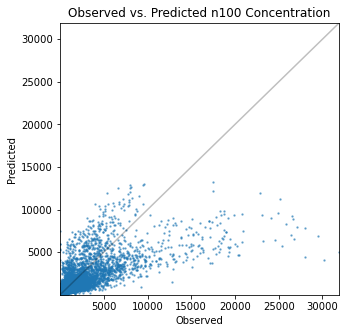

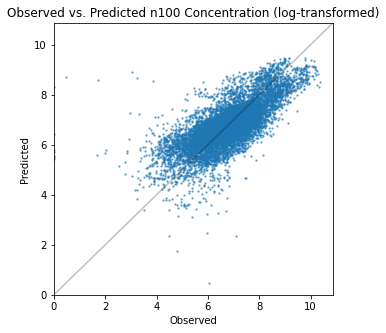

In [175]:
corr_eval(np.array(all_predictions), np.array(all_observations))
corr_eval(np.array(all_log_predictions), np.array(all_log_observations), log_transf=True)
eval_model(all_predictions, all_log_predictions, all_observations, all_log_observations, print_results=True)

Model equation:
n100_log = 0.147*aermr09_log + 0.527*co_log + 0.0*no_log + 0.023*no2_log + 0.049*so2_log + 0.019*d2m + 0.0*t2m + 0.179*nh3_log + 17.881

Correlation between observed and predicted n100 concentration: 0.746
Correlation between observed and predicted n100 concentration (log-transformed): 0.759
R2 value on test set: 0.511800
R2 value on test set (log-transformed): 0.570900
RMSLE on test set: 0.743600
RMSE on test set (log_transformed): 0.749000


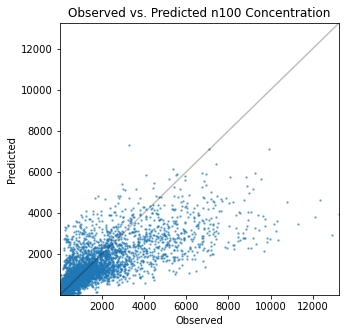

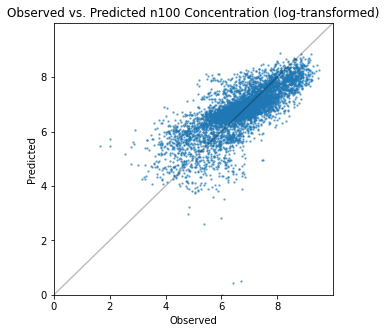

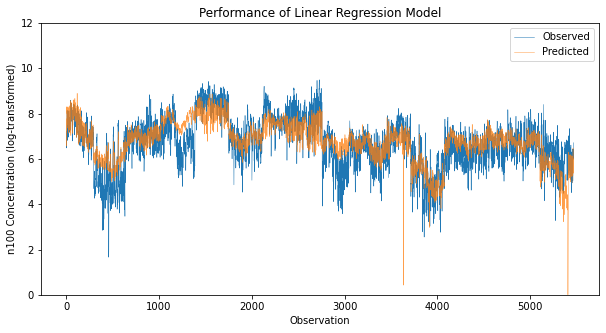

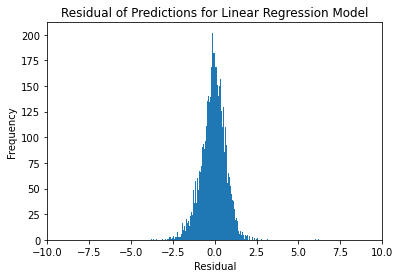

In [176]:
log_transf_n100 = True
train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# sklearn linear regression model using training set
model = LinearRegression(positive=True).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# printing the model evaluation
print_equation(model, predictors)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=True)

# plotting the observed and predicted n100 concentrations against time in log-scale
plot_results('Linear Regression', log_predictions)
plot_residuals('Linear Regression', log_predictions)

Correlation between observed and predicted n100 concentration: 0.559
Correlation between observed and predicted n100 concentration (log-transformed): 0.73
R2 value on test set: 0.106600
R2 value on test set (log-transformed): 0.454800
RMSLE on test set: 0.824400
RMSE on test set (log_transformed): 0.827400


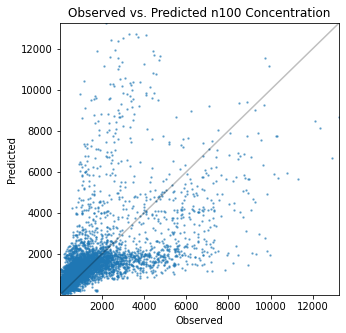

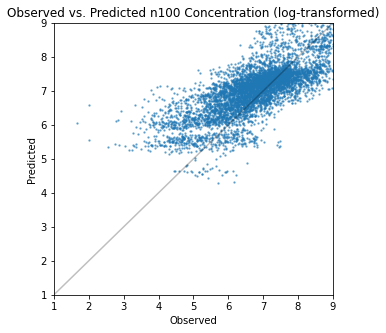

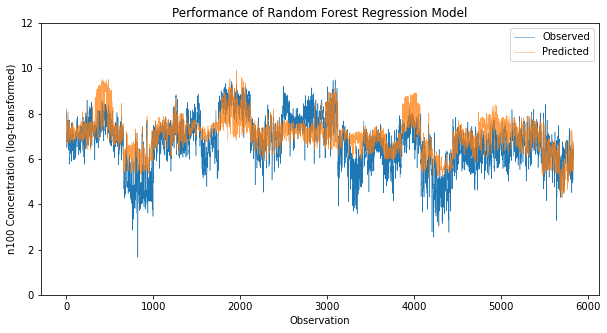

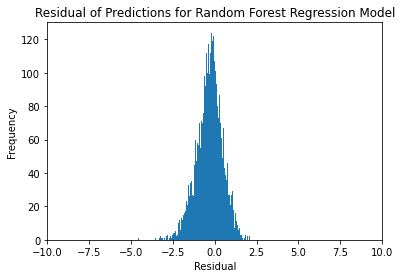

In [11]:
log_transf_n100 = False
train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, all_vars, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# fitting the random forest regression model
model = RandomForestRegressor(max_depth=10).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=True)

        
# plotting the observed and predicted n100 concentrations against time
plot_results('Random Forest Regression', log_predictions)
plot_residuals('Random Forest Regression', log_predictions)